<a href="https://colab.research.google.com/github/mc-ivan/analisis-agricola/blob/main/notebook/Practica4_Analsis_agricola_avanzado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB 4
# Análisis espacial de sostenibilidad de recursos naturales

**Participante**: Ivan Mamani Condori
Fecha: 01/02/2026



📌 Entorno detectado: Google Colab
Mounted at /content/drive
⚠️ 'python-docx' no instalado. Instalando...
✅ 'python-docx' instalado correctamente.
SISTEMA DE ANÁLISIS GEONORTH
📥 Descargando logo corporativo desde URL...
✅ Logo descargado correctamente.
✅ ndvi cargado
✅ ndwi cargado
✅ savi cargado
✅ bsi cargado
✅ yield cargado
✅ water_balance cargado
✅ precipitation cargado
✅ temperature cargado
✅ elevation cargado
✅ slope cargado
✅ zones cargado

📊 Generando visualizaciones...


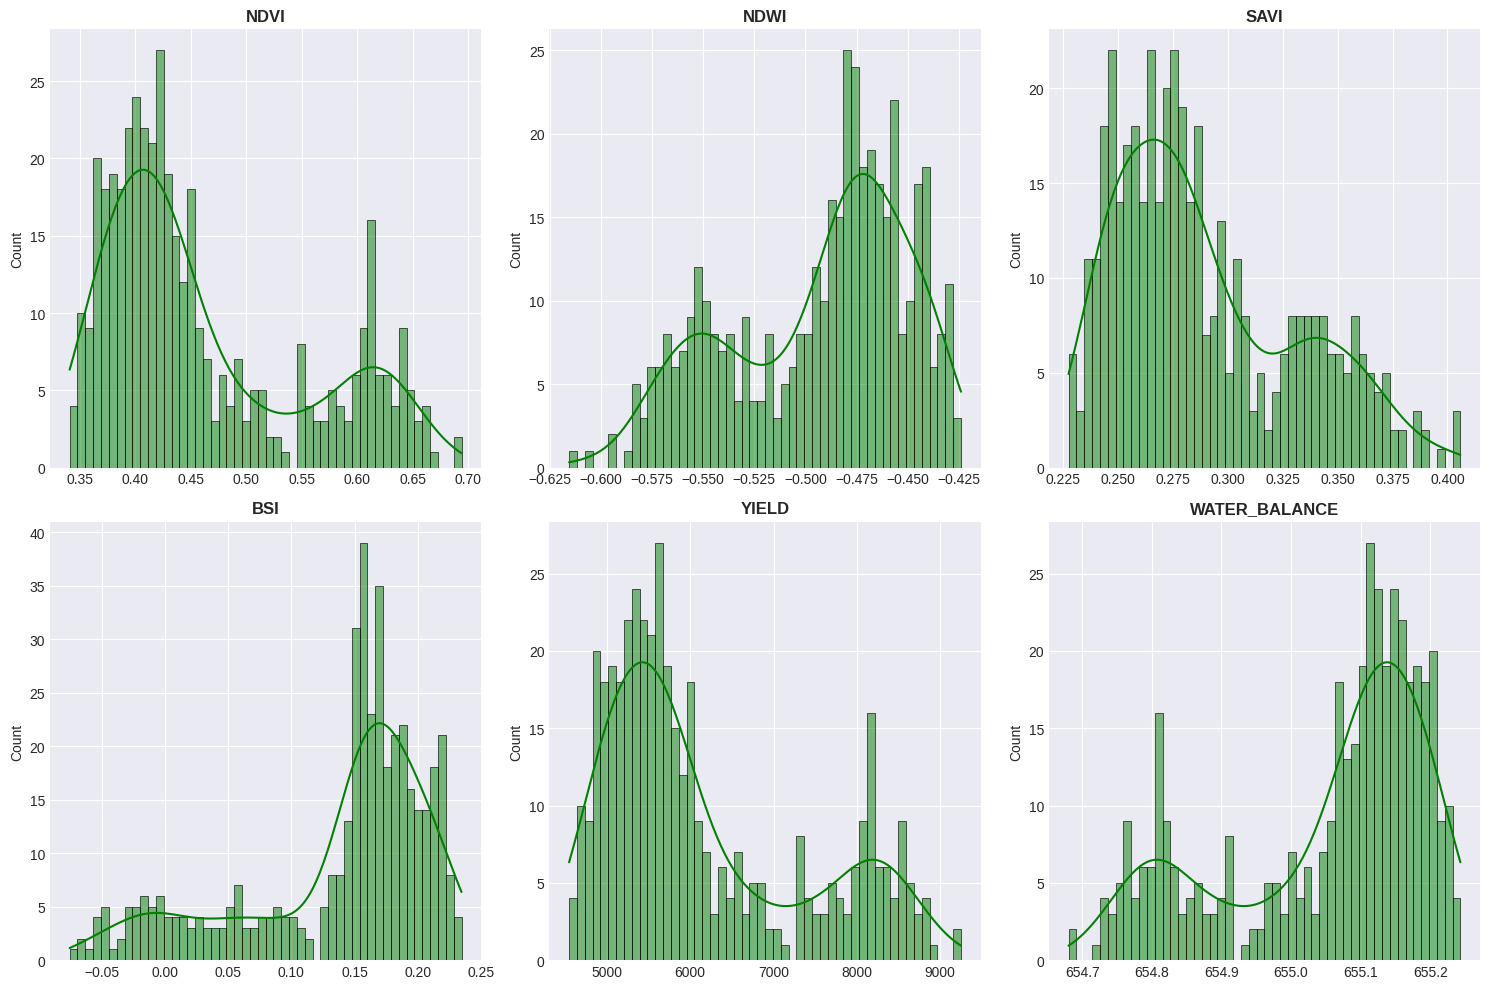

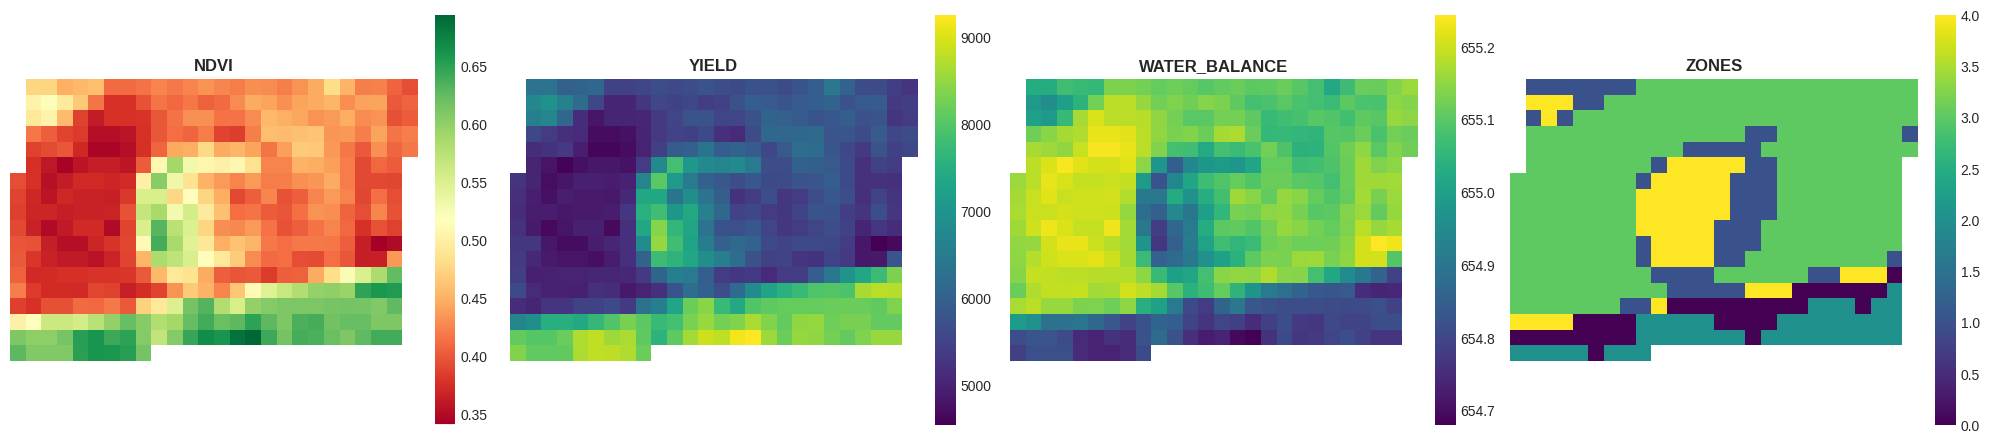


📝 Calculando estadísticas...
         Capa    Media      Mín      Máx  Desv_Est
         NDVI    0.461    0.341    0.694     0.091
         NDWI   -0.493   -0.616   -0.424     0.043
         SAVI    0.290    0.227    0.406     0.041
          BSI    0.137   -0.076    0.235     0.076
        YIELD 6148.760 4545.576 9250.424  1211.078
WATER_BALANCE  655.051  654.680  655.243     0.145
PRECIPITATION  663.764  663.764  663.764     0.000
  TEMPERATURE   28.443   28.443   28.443     0.000
    ELEVATION  298.105  295.000  300.000     1.385
        SLOPE    2.433    0.000    4.182     1.085
        ZONES    2.515    0.000    4.000     1.107
          CSI   -0.927   -1.201   -0.768     0.101

📝 GENERANDO INFORME GEONORTH: outputs/Informe_Tecnico_Geonorth.docx...
✅ Informe corporativo guardado en: outputs/Informe_Tecnico_Geonorth.docx

PROCESO COMPLETADO EXITOSAMENTE


In [1]:
# =============================================================================
# SISTEMA DE ANÁLISIS AGRÍCOLA AVANZADO - GEONORTH
# =============================================================================

import os
import sys
import numpy as np
import pandas as pd
import requests

# --- INTEGRACIÓN CON GOOGLE DRIVE ---
try:
    from google.colab import drive
    IN_COLAB = True
    print("📌 Entorno detectado: Google Colab")
except:
    IN_COLAB = False
    print("📌 Entorno detectado: Local")

# Montar Drive si está en Colab
if IN_COLAB:
    if not os.path.exists('/content/drive'):
        drive.mount('/content/drive')

import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import folium
from folium.plugins import HeatMap, MeasureControl
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# --- GENERACIÓN DE INFORME WORD ---
try:
    import docx
    from docx.shared import Inches, Pt, RGBColor
    from docx.enum.text import WD_ALIGN_PARAGRAPH
    HAS_DOCX = True
except ImportError:
    HAS_DOCX = False
    print("⚠️ 'python-docx' no instalado. Instalando...")
    try:
        import subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "python-docx"])
        import docx
        from docx.shared import Inches, Pt, RGBColor
        from docx.enum.text import WD_ALIGN_PARAGRAPH
        HAS_DOCX = True
        print("✅ 'python-docx' instalado correctamente.")
    except:
        print("❌ No se pudo instalar 'python-docx'. El informe Word no estará disponible.")

# =============================================================================
# 2. CONFIGURACIÓN DE PATHS Y PARÁMETROS
# =============================================================================

class Config:
    """Configuración del proyecto - Geonorth"""
    # Directorios - Configuración de Drive
    if IN_COLAB:
        DATA_DIR = "/content/drive/MyDrive/GEE_Exports"
    else:
        DATA_DIR = "GEE_Exports"

    OUTPUT_DIR = "outputs"
    FIGURES_DIR = "figures"

    # URL del Logo de Geonorth
    LOGO_URL = "https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEiQXCA3ZDW0bQrgKNtU8bR5FYE2CcJkFDUdKvl3cLnUq7tNJ5zSTbXXENCkF8RsjxEmJySQV_AeH0m9EjDVKvETFZnoDsvaNoBCzkubUzPkxguJ9tnp6TBIyHT8i6eDcFoINClVA7H5jk9IolilukfYqGt8gPZGEKN2UDHC2dfKvkeNspJCkkX3jeXBID7h/s1022/ChatGPT%20Image%2024%20ene%202026,%2009_40_57%20a.m..png"
    LOGO_PATH = os.path.join(FIGURES_DIR, "logo_geonorth.png")

    # Información de la Empresa
    COMPANY_NAME = "GEONORTH"
    CEO_NAME = "M.Sc. Edwin Calle Condori"
    CEO_TITLE = "CEO & Founder Geonorth"

    # Archivos de entrada actualizados según GEE
    FILES = {
        'ndvi': 'ndvi_lacruz.tif',
        'ndwi': 'ndwi_lacruz.tif',
        'savi': 'savi_lacruz.tif',
        'bsi': 'bsi_lacruz.tif',
        'yield': 'yield_estimate_lacruz.tif',
        'water_balance': 'water_balance_lacruz.tif',
        'precipitation': 'precipitation_lacruz.tif',
        'temperature': 'temperature_lacruz.tif',
        'elevation': 'elevation_lacruz.tif',
        'slope': 'slope_lacruz.tif',
        'zones': 'management_zones_lacruz.tif'
    }

    CROP_PARAMS = {
        'name': 'Maíz',
        'max_yield': 10000,
        'min_yield': 1000,
        'N_requirement': 180,
        'P_requirement': 60,
        'K_requirement': 120,
        'water_requirement': 500
    }

# Crear directorios si no existen
for dir_path in [Config.DATA_DIR, Config.OUTPUT_DIR, Config.FIGURES_DIR]:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path, exist_ok=True)

# Función para descargar el logo si no existe
def download_logo():
    if not os.path.exists(Config.LOGO_PATH):
        try:
            print(f"📥 Descargando logo corporativo desde URL...")
            response = requests.get(Config.LOGO_URL, stream=True)
            if response.status_code == 200:
                with open(Config.LOGO_PATH, 'wb') as f:
                    for chunk in response.iter_content(1024):
                        f.write(chunk)
                print("✅ Logo descargado correctamente.")
            else:
                print("⚠️ No se pudo descargar el logo (Código de error).")
        except Exception as e:
            print(f"⚠️ Error al descargar el logo: {e}")

# =============================================================================
# 3. PROCESAMIENTO RASTER
# =============================================================================

class RasterProcessor:
    def __init__(self, data_dir=Config.DATA_DIR):
        self.data_dir = data_dir
        self.rasters = {}

    def load_raster(self, raster_name):
        filename = Config.FILES.get(raster_name.lower())
        file_path = os.path.join(self.data_dir, filename)

        if not os.path.exists(file_path):
            print(f"⚠️ No encontrado: {file_path}")
            return False

        try:
            with rasterio.open(file_path) as src:
                data = src.read(1)
                data = np.where(data == src.nodata, np.nan, data)
                data = np.where(np.abs(data) > 1e10, np.nan, data)
                self.rasters[raster_name] = {'data': data}
                print(f"✅ {raster_name} cargado")
                return True
        except Exception as e:
            print(f"❌ Error en {raster_name}: {e}")
            return False

    def load_all(self):
        for name in Config.FILES.keys(): self.load_raster(name)

    def calculate_indices(self):
        if 'ndvi' in self.rasters and 'ndwi' in self.rasters:
            ndvi, ndwi = self.rasters['ndvi']['data'], self.rasters['ndwi']['data']
            self.rasters['csi'] = {'data': np.where(ndwi != 0, ndvi / (ndwi + 1e-10), 0)}

# =============================================================================
# 4. VISUALIZACIÓN
# =============================================================================

class Visualization:
    @staticmethod
    def plot_raster_distribution(rp):
        names = [n for n in list(rp.rasters.keys())[:6] if n in rp.rasters]
        if not names: return
        n_plots = len(names)
        fig, axes = plt.subplots((n_plots+2)//3, min(3, n_plots), figsize=(15, 5*((n_plots+2)//3)))
        axes = axes.flatten() if n_plots > 1 else [axes]
        for idx, name in enumerate(names):
            data = rp.rasters[name]['data'].flatten()
            data = data[~np.isnan(data)]
            if len(data) > 0:
                sns.histplot(data, bins=50, ax=axes[idx], color='green', kde=True)
                axes[idx].set_title(name.upper(), fontweight='bold')
        for idx in range(n_plots, len(axes)): axes[idx].set_visible(False)
        plt.tight_layout()
        plt.savefig(f'{Config.FIGURES_DIR}/distribucion_indices.png', dpi=300)
        plt.show()

    @staticmethod
    def plot_zonal_maps(rp):
        layers = [l for l in ['ndvi', 'yield', 'water_balance', 'zones'] if l in rp.rasters]
        if not layers: return
        fig, axes = plt.subplots(1, len(layers), figsize=(5*len(layers), 5))
        if len(layers) == 1: axes = [axes]
        for i, layer in enumerate(layers):
            im = axes[i].imshow(rp.rasters[layer]['data'], cmap='RdYlGn' if layer == 'ndvi' else 'viridis')
            axes[i].set_title(layer.upper(), fontweight='bold')
            axes[i].axis('off')
            plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.savefig(f'{Config.FIGURES_DIR}/mapas_generales.png', dpi=300)
        plt.show()

# =============================================================================
# 5. GENERACIÓN DE INFORME WORD
# =============================================================================

class WordReportGenerator:
    def __init__(self, df_resumen):
        self.df_resumen = df_resumen
        self.doc = docx.Document() if HAS_DOCX else None

    def generate(self, output_path):
        if not HAS_DOCX: return

        print(f"\n📝 GENERANDO INFORME GEONORTH: {output_path}...")

        # --- ENCABEZADO CON LOGO ---
        if os.path.exists(Config.LOGO_PATH):
            self.doc.add_picture(Config.LOGO_PATH, width=Inches(3))
            last_p = self.doc.paragraphs[-1]
            last_p.alignment = WD_ALIGN_PARAGRAPH.CENTER

        title_p = self.doc.add_heading('Informe de Análisis Agrícola Avanzado', 0)
        title_p.alignment = WD_ALIGN_PARAGRAPH.CENTER

        # Subtítulo con información del proyecto
        info = self.doc.add_paragraph()
        info.alignment = WD_ALIGN_PARAGRAPH.CENTER
        run = info.add_run(f'Proyecto: Agricultura Sostenible - La Cruz\n')
        run.bold = True
        run.font.size = Pt(14)
        info.add_run(f'Fecha: {pd.Timestamp.now().strftime("%d/%m/%Y %H:%M")}\n')
        info.add_run(f'{Config.COMPANY_NAME}').bold = True

        # 1. Resumen Ejecutivo
        self.doc.add_heading('1. Resumen Ejecutivo', level=1)
        self.doc.add_paragraph(
            f"El presente informe técnico detalla los resultados obtenidos mediante el procesamiento de datos satelitales "
            f"y modelos geoespaciales aplicados al cultivo de {Config.CROP_PARAMS['name']} en la zona de La Cruz. "
            "Se han evaluado indicadores clave de vigor vegetal, humedad del suelo, balance hídrico y potencial de rendimiento."
        )

        # 2. Estadísticas del Área
        self.doc.add_heading('2. Estadísticas y Resultados', level=1)
        table = self.doc.add_table(rows=1, cols=len(self.df_resumen.columns))
        try:
            table.style = 'Table Grid'
        except:
            pass

        # Encabezados
        for i, col in enumerate(self.df_resumen.columns):
            table.rows[0].cells[i].text = str(col)

        # Datos
        for _, row in self.df_resumen.iterrows():
            cells = table.add_row().cells
            for i, val in enumerate(row):
                cells[i].text = f"{val:.3f}" if isinstance(val, (float, np.float64)) else str(val)

        # 3. Análisis Visual
        self.doc.add_heading('3. Análisis Visual y Espacial', level=1)

        # Gráfico de Distribución
        dist_img = f'{Config.FIGURES_DIR}/distribucion_indices.png'
        if os.path.exists(dist_img):
            self.doc.add_heading('3.1 Distribución de Índices', level=2)
            self.doc.add_picture(dist_img, width=Inches(6))
            self.doc.add_paragraph("Figura 1: Histogramas de frecuencia que muestran la distribución estadística de los índices.").italic = True

        # Mapas Generales
        maps_img = f'{Config.FIGURES_DIR}/mapas_generales.png'
        if os.path.exists(maps_img):
            self.doc.add_heading('3.2 Mapas de Superficie', level=2)
            self.doc.add_picture(maps_img, width=Inches(6))
            self.doc.add_paragraph("Figura 2: Distribución espacial de NDVI, Rendimiento y Balance Hídrico.").italic = True

        # 4. Conclusiones y Firma
        self.doc.add_heading('4. Conclusiones y Recomendaciones', level=1)
        ndvi_mean = self.df_resumen[self.df_resumen['Capa'] == 'NDVI']['Media'].values[0]
        yield_mean = self.df_resumen[self.df_resumen['Capa'] == 'YIELD']['Media'].values[0]

        conclusion = self.doc.add_paragraph()
        conclusion.add_run("• Estado del Cultivo: ").bold = True
        status = "Excelente" if ndvi_mean > 0.6 else "Estable"
        conclusion.add_run(f"La salud vegetal se reporta como {status} con un NDVI promedio de {ndvi_mean:.2f}.\n")

        conclusion.add_run("• Proyección de Rendimiento: ").bold = True
        conclusion.add_run(f"Se estima una producción promedio de {yield_mean:.0f} kg/ha para el lote analizado.\n")

        conclusion.add_run("• Gestión de Recursos: ").bold = True
        conclusion.add_run("Se recomienda el monitoreo constante de las zonas identificadas con balance hídrico crítico.")

        # FIRMA DEL GERENTE
        self.doc.add_paragraph("\n\n\n")
        signature = self.doc.add_paragraph()
        signature.alignment = WD_ALIGN_PARAGRAPH.RIGHT
        signature.add_run("______________________________\n").bold = True
        signature.add_run(f"{Config.CEO_NAME}\n").bold = True
        signature.add_run(Config.CEO_TITLE).italic = True

        # Guardar Documento
        self.doc.save(output_path)
        print(f"✅ Informe corporativo guardado en: {output_path}")

# =============================================================================
# 6. FUNCIÓN PRINCIPAL
# =============================================================================

def main():
    print("=" * 70)
    print(f"SISTEMA DE ANÁLISIS GEONORTH")
    print("=" * 70)

    # Descargar logo antes de empezar
    download_logo()

    rp = RasterProcessor()
    rp.load_all()
    rp.calculate_indices()

    if not rp.rasters:
        print("❌ Error: No se detectaron archivos de entrada.")
        return

    # Generar gráficos
    print("\n📊 Generando visualizaciones...")
    Visualization.plot_raster_distribution(rp)
    Visualization.plot_zonal_maps(rp)

    # Estadísticas
    print("\n📝 Calculando estadísticas...")
    stats = []
    for name, info in rp.rasters.items():
        data = info['data']
        valid = data[~np.isnan(data)]
        if len(valid) > 0:
            stats.append({
                'Capa': name.upper(),
                'Media': np.mean(valid),
                'Mín': np.min(valid),
                'Máx': np.max(valid),
                'Desv_Est': np.std(valid)
            })

    df_resumen = pd.DataFrame(stats)
    print(df_resumen.to_string(index=False))

    # Guardar CSV y generar Word
    res_path = os.path.join(Config.OUTPUT_DIR, 'resumen_estadistico.csv')
    df_resumen.to_csv(res_path, index=False)

    report_file = os.path.join(Config.OUTPUT_DIR, 'Informe_Tecnico_Geonorth.docx')
    WordReportGenerator(df_resumen).generate(report_file)

    print("\n" + "=" * 70)
    print("PROCESO COMPLETADO EXITOSAMENTE")
    print("=" * 70)

if __name__ == "__main__":
    main()
